## imports

In [1]:
import usit.p

from useful_scit.imps2.defs import (
    pd, np, xr, za, mpl, sns, os, glob, 
    dt, sys, crt, Path, pprint, ucp, log, pjoin, plt
)
from useful_scit.imps2.defs import *


In [2]:
from useful_scit.imps2.defs import *

In [3]:
import sys; sys.path.insert(0, '../..')

In [4]:
from wiebke_flx import constants as co

In [5]:
sns.set_theme()

## constants

In [253]:
DOUT = './plots'
os.makedirs(DOUT,exist_ok=True)

DOUTH = './plots/hourly'
os.makedirs(DOUTH,exist_ok=True)

# d1 = '2018-02-19T12:00:00'
RRL = 'releases'
ZM = 'ZMID'
R = 'R_CENTER'
T = 'TH_CENTER'
D = 'DIS'
TO = 'TOPOGRAPHY'
C = 'CONC'
A = 'AGE'
CHC_LAT = -16.350427
CHC_LON = -68.131335

LT = RL =  'BOT'

## open date df

In [146]:
ddf1 = pd.read_csv('../dates_tsv.tsv',sep='\s+',parse_dates=[0,1])

ddf1['dlt_end'] = ddf1['dlt1'] - pd.Timedelta(minutes=1)
ddf1['dlt_sta'] = ddf1['dlt0']

ddf1['h_range'] = (ddf1['dlt1'] - ddf1['dlt0']).dt.seconds/3600

ddf1

,dlt0,dlt1,priority,dlt_end,dlt_sta,h_range
0,2018-05-20 03:00:00,2018-05-20 06:00:00,1,2018-05-20 05:59:00,2018-05-20 03:00:00,3.0
1,2018-05-15 06:00:00,2018-05-15 07:00:00,1,2018-05-15 06:59:00,2018-05-15 06:00:00,1.0
2,2018-02-19 07:00:00,2018-02-19 09:00:00,1,2018-02-19 08:59:00,2018-02-19 07:00:00,2.0
3,2018-03-28 20:00:00,2018-03-28 22:00:00,1,2018-03-28 21:59:00,2018-03-28 20:00:00,2.0
4,2018-05-16 09:00:00,2018-05-16 18:00:00,2,2018-05-16 17:59:00,2018-05-16 09:00:00,9.0
5,2018-05-19 13:00:00,2018-05-19 14:00:00,2,2018-05-19 13:59:00,2018-05-19 13:00:00,1.0
6,2018-05-11 08:00:00,2018-05-11 09:00:00,3,2018-05-11 08:59:00,2018-05-11 08:00:00,1.0
7,2018-05-18 07:00:00,2018-05-18 08:00:00,3,2018-05-18 07:59:00,2018-05-18 07:00:00,1.0


## open ds

### make it local time

In [147]:
ds = xr.open_dataset(co.ds_asl)
ds[RL] = ds[RRL] - pd.Timedelta(hours=4)

In [148]:
ds= ds.swap_dims({RRL:RL})

In [149]:
ds[D] = ds[R] * 100
ds[D].attrs = {'long_name':'distance from CHC','units':'km'}
ds = ds.set_coords(D)

## plot map

In [150]:
def add_mod(ax, date_str = '2018-01-09'):
    from owslib.wmts import WebMapTileService
    import warnings
    warnings.filterwarnings('ignore',category=RuntimeWarning)
    warnings.filterwarnings('ignore',category=UserWarning)
    URL = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
    wmts = WebMapTileService(URL)

    # Layers for MODIS true color and snow RGB
    layer = 'MODIS_Aqua_SurfaceReflectance_Bands143'
    layer = 'MODIS_Terra_SurfaceReflectance_Bands143'
    #           'MODIS_Terra_CorrectedReflectance_Bands367'
    ax.add_wmts(wmts, layer, wmts_kwargs={'time': date_str}, rasterized=True,)

In [151]:
xxll = dict(x='XLONG',y='XLAT')

In [176]:
def pmap(d1,d2):
    s1 = ds.loc[{RL:slice(d1,d2)}].mean(RL)
    s = splot(
        1,2,
        subplot_kw={'projection':crt.crs.PlateCarree()},
        dpi=100,
        figsize=(15,6)
             )
    # ax = s.axf[0]
    rr = [None,15]
    xx = [np.arange(-90,-49,10),np.arange(-68.5,-67.4,.5)]
    yy = [np.arange(-40,-1,10),np.arange(-17,-15.9,.5)]
    for i in [0,1]:
        ax = s.axf[i]
        _s = s1[{R:slice(0,rr[i])}][C].sum(ZM)
        _s.where(_s>1e2).plot(**xxll,cmap='Reds',ax=ax)
        add_mod(ax,d1.strftime('%Y-%m-%d'))
        ax.set_xticks(xx[i])
        ax.set_yticks(yy[i])
        tit = f"{d1.strftime('%Y-%m-%dT%H:%M')}-{d2.strftime('%Y-%m-%dT%H:%M')}"
        ax.set_title(tit)

    s.f.subplots_adjust(wspace=.5)
    return s 
    

In [175]:
def phgt(d1,d2):
    s1 = ds.loc[{RL:slice(d1,d2)}].mean(RL)
    hg = (s1[C]*s1[ZM]).sum([T,ZM])/s1[C].sum([T,ZM])

    to = (s1[C]*s1[TO]).sum([T,ZM])/s1[C].sum([T,ZM])

    s = splot(
        1,2,        
        dpi=100,
        figsize=(15,6))
    rr = [None,15]
    for i in [0,1]:
        ax =s.axf[i]
        s1[C][{R:slice(0,rr[i])}].sum(T).plot(cmap='Reds',x=D,y=ZM,ax =ax)
        hg.plot(x=D,ax=ax,c='b',lw=2)
        to.plot(x=D,ax=ax,c='k',lw=2)
    return s

In [172]:
d1 = ddf1.iloc[0]['dlt_sta']
d2 = ddf1.iloc[0]['dlt_end']
tit = f"{d1.strftime('%Y-%m-%dT%H:%M')}-{d2.strftime('%Y-%m-%dT%H:%M')}.pdf"
tit

pmap(d1,d2)
phgt(d1,d2)

## plots out

In [281]:
def save_figs(i,dout = DOUT,ddf1=ddf1):
    d1 = ddf1.iloc[i]['dlt_sta']
    d2 = ddf1.iloc[i]['dlt_end']
    titA = f"{d1.strftime('%Y-%m-%dT%H_%M')}-{d2.strftime('%Y-%m-%dT%H_%M')}_A.pdf"
    titB = f"{d1.strftime('%Y-%m-%dT%H_%M')}-{d2.strftime('%Y-%m-%dT%H_%M')}_B.pdf"

    sA = pmap(d1,d2)
    plt.close(sA.f)
    sB = phgt(d1,d2)
    plt.close(sB.f)

    poutA = pjoin(dout,titA)
    poutB = pjoin(dout,titB)

    sA.f.savefig(poutA)
    sB.f.savefig(poutB)

In [181]:
for i in range(len(ddf1)):
    save_figs(i)

### detailed plots

In [282]:
i = 0 

In [291]:
for i in range(2,len(ddf1)):
    r = ddf1.iloc[i]

    p = f"{r['dlt_sta'].strftime('%Y-%m-%dT%H_%M')}-{r['dlt_end'].strftime('%Y-%m-%dT%H_%M')}"
    p = pjoin(DOUTH,p)
    os.makedirs(p,exist_ok=True)

    e0 = r['dlt_sta'] - pd.Timedelta(hours=5)

    e1 = r['dlt_end'] + pd.Timedelta(hours=5)

    ee0 = pd.date_range(e0,e1,freq='H')
    ee1 = ee0 + pd.Timedelta(minutes=59)

    ndf = pd.DataFrame([ee0,ee1],index=['dlt_sta','dlt_end']).T
    ndf

    for j in range(len(ndf)):
        save_figs(j,dout=p,ddf1=ndf)

## time series summary stats 

### open ds 

In [185]:
ss = xr.open_dataset('/Volumes/Transcend/diego_tr/flexpart_management/flexpart_management/tmp_data/cluster_series_v31.nc')
ss[RL] = ss[RRL] - pd.Timedelta(hours=4)
ss=ss.swap_dims({RRL:RL})

### plot 

In [246]:
def plot_series(i):
    d0 = ddf1.iloc[i]['dlt0']
    d1 = ddf1.iloc[i]['dlt1']

    d00, d11 = d0 - pd.Timedelta(hours=20),d1 + pd.Timedelta(hours=20)

    ss1 = ss.loc[{RL:slice(d00,d11)}]

    cc = [
    #     'conc_all',
        'clock_dir_all',
        'age_all',
        'R_DIS_all',
        'ZSL_all',
        'ZGL_all',
    ]

    mpl.rcParams["legend.loc"] = 'upper right'

    s = splot(6,1,figsize=(8,6*3),sharex=True,dpi=50)
    ax=s.axf[0]
    ss1['conc_all'].loc[{'normalized':1}].plot.line(x=RL,ax=ax)
    ax.axvspan(d0,d1,color='k',alpha=.2)

    for j,c in enumerate(cc):
    #     splot()
        # ss1[c].loc[{'normalized':1}].plot.line(x=RL)
        ax=s.axf[j+1]
        ss1[c].plot.line(x=RL,ax=ax)
        ax.axvspan(d0,d1,color='k',alpha=.2)
    return s 

#### example

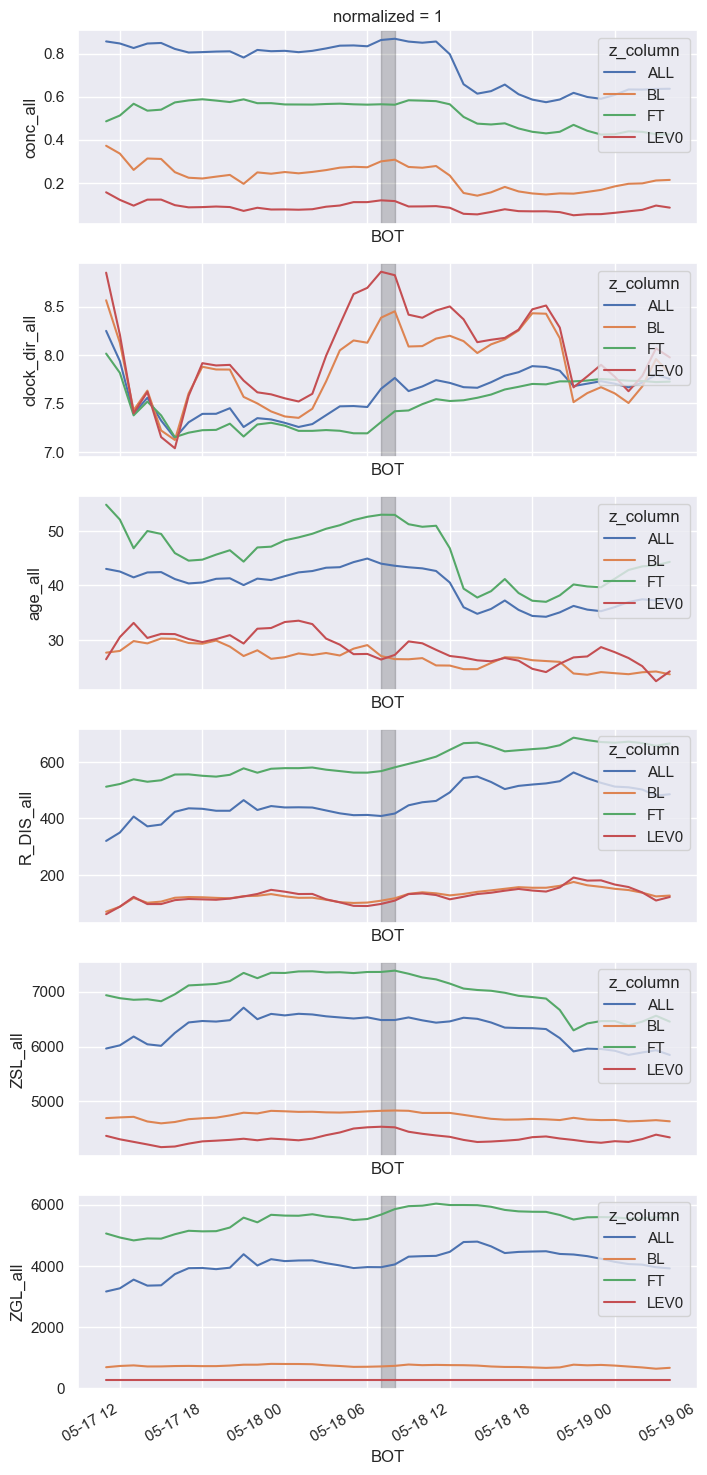

In [248]:
i =7
plot_series(i)

#### to files 

In [251]:
def save_figs2(i):
    d1 = ddf1.iloc[i]['dlt_sta']
    d2 = ddf1.iloc[i]['dlt_end']
    titA = f"series_{d1.strftime('%Y-%m-%dT%H_%M')}-{d2.strftime('%Y-%m-%dT%H_%M')}_A.pdf"
    titB = f"series_{d1.strftime('%Y-%m-%dT%H_%M')}-{d2.strftime('%Y-%m-%dT%H_%M')}_B.pdf"

    sA = plot_series(i)
    plt.close(sA.f)


    poutA = pjoin(DOUT,titA)


    sA.f.savefig(poutA)


In [252]:
for i in range(len(ddf1)):
    save_figs2(i)